In [1]:
%matplotlib inline
%load_ext iminizinc
import asyncio
from IPython.display import HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive

from problems import nqueens, us_map_coloring
from draw_utils import draw_nqueens, draw_us_map
from slide_utils import SlideController
from backtracking_search import nqueens_backtracking
from utils import autoupdate_cells

<IPython.core.display.Javascript object>

MiniZinc to FlatZinc converter, version 2.2.3, build 34907429
Copyright (C) 2014-2018 Monash University, NICTA, Data61


In [2]:
HTML('<script src="http://d3js.org/d3.v3.min.js" charset="utf-8"></script>')

# Constraint Programming

## Introduction

Constraints naturally arise in a variety of interactions and fields of study such as game theory, social studies, operations research, engineering, and artificial intelligence. A constraint refers to the relationship between the state of objects, such as the constraint that the three angles of a triangle must sum to 180 degrees. Note that this constraint has not precisely stated each angle's value and still allows some flexibility. Said another way, the triangle constraint restricts the values that the three variables (each angle) can take, thus providing information that will be useful in finding values for the three angles.

Another example of a constrained problem comes from the recently-aired hit TV series *Buddies*, where a group of five (mostly mutual) friends would like to sit at a table with three chairs in specific arrangements at different times, but have requirements as to who they will and will not sit with.

Another example comes from scheduling: at the university level, there is a large number of classes that must be scheduled in various classrooms such that no professor or classroom is double booked. Further, there are some constraints on which classes can be scheduled for the same time, as some students will need to be registered for both.

Computers can be employed to solve these types of problems, but in general these tasks are computationally intractible and cannot be solved efficiently in all cases with a single algorithm \cite{Dechter2003}. However, by formalizing these types of problems in a constraint processing framework, we can identify classes of problems that can be solved using efficient algorithms.

Below, we discuss generally the three core concepts in constraint programming: **modeling**, **inference**, and **search**. Modeling is an important step that can greatly affect the ability to efficienctly solve constrained problems and inference (e.g., constraint propagation) and search are solution methods. Basic constraint propagation and state-space search are building blocks that state of the art solvers incorporate.

### Modeling

A **constraint satisfaction problem** (CSP) is formalized by a *constraint network*, which is the triple $\mathcal{R} = \langle X,D,C\rangle$, where
- $X = \{x_i\}_{i=1}^n$ is the set of $n$ variables
- $D = \{D_i\}_{i=1}^n$ is the set of variable domains, where the domain of variable $x_k$ is $D_k$
- $C = \{C_i\}_{i=1}^m$ is the set of constraints on the values that each $x_i$ can take on. Specifically,
    - Each constraint $C_i = \langle S_i,R_i\rangle$ specifies allowed variable assignments.
    - $S_i \subset X$ contains the variables involved in the constraint, called the *scope* of the constraint.
    - $R_i$ is the constraint's *relation* and represents the simultaneous legal value assignments of variables in the associated scope.
        - For example, if the scope of the first constraint is $S_1 = \{x_3, x_8\}$, then the relation $R_1$ is a subset of the Cartesian product of those variables' domains: $R_1 \subset D_3 \times D_8$, and an element of the relation $R_1$ could be written as a 2-tuple $(a,b)\in R_1$.

Each variable in a CSP can be assigned a value from its domain. A **complete assignment** is one in which every variable is assigned and a **solution** to a CSP is a consistent (or legal w.r.t. the constraints) complete assignment. 

Note that for a CSP model, *any* consistent complete assignment of the variables (i.e., where all constraints are satisfied) constitutes a valid solution; however, this assignment may not be the "best" solution. Notions of optimality can be captured by introducing an objective function which is used to find a valid solution with the lowest cost. This is referred to as a **constraint *optimization* problem** (COP). We will refer generally to CSPs with the understanding that a CSP can easily become a COP by introducing a heuristic.

In this notebook, we will restrict ourselves to CSPs that can be modeled as having **discrete, finite domains**. This helps us to manage the complexity of the constraints so that we can clearly discuss the different aspects of CSPs. Other variations exist such as having disrete but *infinite* domains, where constraints can no longer be enumerated as combinations of values but must be expressed as either linear or nonlinear inequality constraints, such as $T_1 + d_1 \leq T_2$. Therefore, infinite domains require a different constraint language and special algorithms only exist for linear constraints. Additionally, the domain of a CSP may be continuous. With this change, CSPs become mathematical programming problems which are often studied in operations research or optimization theory, for example.

### Modeling as a Graph

In a general CSP, the *arity* of each constraint is arbitrary. We can have unary constraints on a single variable, binary constraints between two variables, or $n$-ary constraints between $n$ variables. However, having more than binary constraints adds complexity to the algorithms for solving CSPs. It can be shown that every finite-domain constraint can be reduced to a set of binary constraints by adding enough auxiliary variables \cite{AIMA}. Therefore, since we are only discussing CSPs with finite domains, we will assume that the CSPs we are working with have only unary and binary constraints, meaning that each constraint scope has at most two variables.

An important view of a binary constraint network that defines a CSP is as a graph, $\langle\mathcal{V},\mathcal{E}\rangle$. In particular, the each vertex corresponds to a variable, $\mathcal{V} = X$, and the edges of the graph $\mathcal{E}$ correspond to various constraints between variables. Since we are only working with binary and unary constraint networks, it is easy to visualize a graph corresponding to a CSP. For constraint networks with more than binary constraints, the constraints must be represented with a hypergraph, where hypernodes are inserted that connect three or more variables together in a constraint.

For example, consider a CSP $\mathcal{R}$ with the following definition
\begin{align}
X &= \{x_1, x_2, x_3\} \\
D &= \{D_1, D_2, D_3\},\  \text{where}\; D_1 = \{0,5\},\ D_2 = \{1,2,3\},\ D_3 = \{7\} \\
C &= \{C_1, C_2, C_3\},
\end{align}
where
\begin{align}
C_1 &= \langle S_1, R_1 \rangle = \langle \{x_1\}, \{5\} \rangle \\
C_2 &= \langle S_2, R_2 \rangle = \langle \{x_1, x_2\}, \{(0, 1), (0,3), (5,1)\} \rangle \\
C_3 &= \langle S_3, R_3 \rangle = \langle \{x_2, x_3\}, \{(1, 7), (2, 7)\} \rangle.
\end{align}
The graphical model of this CSP is shown below.

<img src="images/example_graph.png" width="35%" align="center"/>


### Solving

The goal of formalizing a CSP as a constraint network model is to efficiently solve it using computational algorithms and tools. **Constraint programming** (CP) is a powerful tool to solve combinatorial constraint problems and is the study of computational systems based on constraints. Once the problem has been modeled as a formal CSP, a variety of computable algorithms could be used to find a solution that satisfies all constraints.

In general, there are two methods used to solve a CSP: search or inference. In previous 16.410/413 problems, **state-space search** was used to find the best path through some sort of graph or tree structure. Likewise, state-space search could be used to find a valid "path" through the CSP that satisfies each of the local constraints and is therefore a valid global solution. However, this approach would quickly become intractable as the number of variables and the size of each of their domains increase.

In light of this, the second solution method becomes more attractive. **Constraint propagation**, a specific type of inference, is used to reduce the number of legal values from a variable's domain by pruning values that would violate the constraints of the given variable. By making a variable locally consistent with its constraints, the domain of adjacent variables may potentially be further reduced as a result of missing values in the pairwise constraint of the two variables. In this way, by making the first variable consistent with its constraints, the constraints of neighboring variables can be re-evaluated, causing a further reduction of domains through the propagation of constraints. These ideas will later be formalized as $k$-consistency.

Constraint propagation may be combined with search, using the pros of both methods simultaneously. Alternatively, constraint propagation may be performed as a pre-processing pruning step so that search has a smaller state space to search over. Sometimes, constraint propagation is all that is required and a solution can be found without a search step at all.

After giving examples of modeling CSPs, this notebook will explore a variety of solution methods based on constraint propagation and search.

---

## Problem Models

Given a constrained problem, it is desirable to identify an appropriate constraint network model $\mathcal{R} = \langle X,D,C\rangle$ that can be used to find its solution. Modeling for CSPs is an important step that can dramatically affect the difficulty in enumerating the associated constraints or efficiency of finding a solution.

Using the general ideas and formalisms from the previous section, we consider two puzzle problems and model them as CSPs in the following sections.

### N-Queens

The N-Queens problem (depicted below for 8 queens) is a well-know puzzle among computer scientists and will be used as a recurring example throughout this notebook. The problem statement is as follows: given any integer $N$, the goal is to place $N$ queens on an $N\times N$ chessboard satisfying the constraint that no two queens threaten each other. A queen can threaten any other queen that is on the same row, column, or diagonal.


In [5]:
# Example n-queens
draw_nqueens(nqueens(4))

<IPython.core.display.Javascript object>

Now let's try to understand the problem formally.

#### Attempt 1

To illustrate the effect of modeling, we first consider a (poor) model for the N-Queens constraint problem, given by the following definitions:
\begin{align}
X &= \{x_i\}_{i=1}^{N^2}                      && \text{(Chessboard positions)} \\
D &= \{D_i\}_{i=1}^{N^2},\ \text{where}\; D_i = \{0, 1,2,\dots,N\}  && \text{(Empty or the $k^\text{th}$ queen)}
\end{align}

Without considering constraints, the size of the state space (i.e., the number of assignments) is an enormous $(N+1)^{N^2}$. For only $N=4$ queens, this becomes $5^{16} \approx 153$ billion states that could potentially be searched.

Expressing the constraints of this problem in terms of the variables and their domains also poses a challenge. Because of the way we have modeled this problem, there are six primary constraints to satisfy:
1. Exactly $N$ chess squares shall be filled (i.e., there are only $N$ queens and all of them must be used)
1. The $k^\text{th}$ queen, ($1\le k\le N$) shall only be used once.
1. No queens share a column
1. No queens share a row
1. No queens share a positive diagonal (i.e., a diagonal from bottom left to top right)
1. No queens share a negative diagonal (i.e., a diagonal from top left to bottom right)

To express these constraints mathematically, we first let $Y\triangleq\{1\le i\le N^2|x_i\in X,x_i\ne 0\}$ be the set of chess square numbers that are non-empty and $Z \triangleq \{x\in X|x\ne 0\}$ be the set of queens in those chess squares (unordered). With pointers back to which constraint they satisfy, the expressions are:
\begin{align}
|Z| = |Y| &= N && (C1) \\
z_i-z_j &\ne 0 && (C2) \\
|y_i-y_j| &\ne N && (C3) \\
\left\lfloor\frac{y_i-1}{N}\right\rfloor &\ne \left\lfloor\frac{y_j-1}{N}\right\rfloor && (C4) \\
|y_i-y_j| &\ne (N-1) && (C5) \\
|y_i-y_j| &\ne (N+1), && (C6)
\end{align}
where $z_i, z_j\in Z$ and $y_i,y_j\in Y, \forall i\ne j$, and applying $|\cdot|$ to a set is the set's cardinalilty (i.e., size) and applied to a scalar is the absolute value. Additionally, we use $\lfloor\cdot\rfloor$ as the floor operator. Notice how we are able to express all the constraints as pairwise (binary).

We can count the number of constraints in the this model as a function of $N$. In each pairwise constraint (C2)-(C6), there are $N$ choose $2$ unique pairs. Since we have 5 different types of pairwise constraints, we have that the number of constraints, $\Gamma$ is
\begin{equation}
\Gamma(N) = 5 {N \choose 2} + 1 = \frac{5N!}{2!(N-2)!} + 1,
\end{equation}
where the plus one comes from the single constraint for (C1). Thus, $\Gamma(N=4) = 31$.

Examining the size of the state space in this model, we see the infeasibility of simply performing a state-space search and then performing a goal test that encodes the problem constraints. This motivates the idea of efficiently using constraints either before or during our solution search, which we will explore in the following sections.

#### Attempt 2

Motivated by the desire to do less work in searching and writing constraints, we consider another model of the N-Queens problem. We wish to decrease the size of the state space and number and difficulty of writing the constraints. Good modeling involves cleverly choosing variables and their semantics so that constraints are implicitly encoded, requiring less explicit constraints.

We can achieve this by encoding the following assumptions:
1. assume one queen per column;
1. an assignment determines which row the $i^\text{th}$ queen should be in.

With this understanding, we can write the constraint network as
\begin{align}
X &= \{x_i\}_{i=1}^{N}                      && \text{(Queen $i$ in the $i^\text{th}$ column)} \\
D &= \{D_i\}_{i=1}^{N},\ \text{where}\; D_i = \{1,2,\dots,N\}  && \text{(The row in which the $i^\text{th}$ queen should be placed)}.
\end{align}

Now considering the size of the state space without constraints, we see that this intelligent encoding reduces the size to only $N^N$ assignments.

Writing down the constraints is also easier for this model. In fact, we only need to address constraints (C4)-(C6) from above, as (C1)-(C3) are taken care of by intelligently choosing our variables and their domains. The expressions, $\forall x_i,x_j\in X, i\ne j$, are
\begin{align}
x_i &\ne x_j && \text{(C4)} \\
|x_i-x_j| &\ne |i-j|. && \text{(C5, C6)}
\end{align}

With this reformulation, the number of constraints is
\begin{equation}
\Gamma(N) = 2 {N \choose 2} = \frac{N!}{(N-2)!}.
\end{equation}
Thus $\Gamma(N) = 12$.

We have successfully modeled the N-Queens problem with a reduced state space and with only two pairwise constraints. Both of these properties will allow the solvers discussed next to more efficiently find solutions to this CSP.

#### First MiniZinc model

Let us now introduce [MiniZinc](https://www.minizinc.org/), a **high-level**, **solver-independent** language to express constraint programming problems and solve them. It has a large library of constraints already encoded that we can exploit to encode our problem.

A very useful constraint is `alldifferent(array[int] of var int: x)`, which is one of the most studied and used constraint in constraint programming. As the name suggest it takes an array of variables and constrains them to take different values.

Now the reader can notice that we can write (C1), (C2) and (C3) of out N-Queens leveraging the `alldifferent` constraint. As result we get the following model. 

In [6]:
%%minizinc
include "globals.mzn";

int: n = 4;
array[1..n] of var 1..n: queens;

constraint all_different(queens);
constraint all_different([queens[i]+i | i in 1..n]);
constraint all_different([queens[i]-i | i in 1..n]);

solve satisfy;

{'queens': [3, 1, 4, 2]}

Here we are asking MiniZinc to solve find any feasible solution (`solve satisfy`) given the constraints.

### Map Coloring

Map coloring is another classic example of a CSP. Consider the map of Australia shown below (from \cite{AIMA}). The goal is to assign a color to Australia's sevem territories such that no neighboring regions share the same color. We are further constrained by only being able to use three colors (e.g., <span style="color:red;font-weight:bold">R</span>, <span style="color:green;font-weight:bold">G</span>, <span style="color:blue;font-weight:bold">B</span>). Next to the map is the constraint graph representation of this specific map-coloring problem.

<table width="70%">
<tr>
    <td><img src="images/mapcoloring_map.png" align="center"/></td>
    <td><img src="images/mapcoloring_graph.png" align="center"/></td>
</tr>
</table>

The constraint network model $\mathcal{R}=\langle X,D,C \rangle$ for the general map-coloring problem with $N$ regions and $M$ colors is defined as:
\begin{align}
X &= \{x_i\}_{i=1}^N && \text{(Each region)} \\
D &= \{D_i\}_{i=1}^N,\ \text{where}\; D_i = \{c_j\}_{j=1}^M,   && \text{(Available colors)}
\end{align}
and the constraints are encoded as
\begin{align}
\forall x_i\in X: x_i &\ne n_j,\ \forall n_j\in\mathcal{N}(x_i), && \text{(Each region cannot have the same color as any of its neighbors)}
\end{align}
where the neighborhood of the region $x_i$ is defined as the set $\mathcal{N}(x_i) = \{x_j\in X| A_{ij}=1,i\ne j, \forall j\}$. The matrix $A\in\mathbb{Z}_{\ge 0}^{N\times N}$ is called the *adjacency matrix* of a graph with $N$ vertices and represents the variables that a given variable is connected to by constraints (i.e., edges). The notation $A_{mn}$ indexes into the matrix by row $m$ and column $n$.

We will use the map coloring problem as a COP example later on.

---

## Constraint Propagation Methods

As previously mentioned, the domain size of a CSP can be dramatically reduced by removing values from variable domains that would violate the relevant constraints. This idea is called **local consistency**. By representing a CSP as a binary constraint graph, making a graph locally consistent amounts to visiting the $i^\text{th}$ node and for each of the values in the domain $D_i$, removing the values of neighboring domains that would cause an illegal assignment.

A great example of the power of constraint propagation is seen in Sudoku puzzles. These puzzles are designed to be solved by constraint propagation alone. By enforcing local consistency throughout the puzzle, the unique solution is found without the need for search.

While there are multiple forms of consistency, we will forgo a discussion of node consistency (single node), path consistency (3 nodes), and generally **$k$-consistency** ($k$ nodes) to focus on arc consistency.

### Arc Consistency

The most well-known notion of local consistency is **arc consistency**, where the key idea is to remove values of variable domains that can never satisfy a specified constraint. The arc $\langle x_i, x_j \rangle$ between two variables $x_i$ and $x_j$ is said to be arc consistent if $\langle x_i, x_j \rangle$ and $\langle x_j, x_i \rangle$ are *directed* arc consistent.

The arc $\langle x_i, x_j \rangle$ is **directed arc consistent** (from $x_i$ to $x_j$) if $\forall a_i \in D_i \; 
\exists a_j \in D_j$ s.t. $\langle a_i, a_j \rangle \in C_{ij}$. The notation $C_{ij}$ represents a constraint between variables $x_i$ and $x_j$ with a relation on their domains $D_i, D_j$. In other words, we write a constraint $\langle \{x_i, x_j\}, R \rangle$ as $C_{ij} = R$, where $R\subset D_i\times D_j$.

As an example, consider the following simple constraint network:
\begin{align}
X &= \{x_1, x_2\} \\
D &= \{D_1, D_2\},\ \text{where}\; D_1=\{1,3,5,7\}, D_2=\{2,4,6,8\} \\
C &= \{C_{12}\},
\end{align}
where $C_{12} = \{(1,2),(3,8),(7,4)\}$ lists legal assignment relationships between $x_1$ and $x_2$.

To make $\langle x_1, x_2 \rangle$ directed arc consistent, we would remove the values from $D_1$ that could never satisfy the constraint $C_{12}$. The original domains are shown on the left, while the directed arc consistent graph is shown on the right. Note that 6 is not removed from $D_2$ because directed arc consistency only considers consistency in one direction.

<table width="70%">
<tr style="background-color:white">
    <td><img src="images/directedac_1a.png" align="center"/></td>
    <td><img src="images/directedac_1b.png" align="center"/></td>
</tr>
</table>

Similarly, we can make $\langle x_2, x_1 \rangle$ directed arc consistent by removing 6 from $D_2$. This results in an arc consistent graph, shown below.

<img src="images/example_ac.png" width="35%"/>

#### Sound but Incomplete
By making a CSP arc consistent, we are guaranteed that solutions to the CSP will be found in the reduced domain of the arc consistent CSP. However, we are not guaranteed that any arbitrary assignment of variables from the reduced domain will offer a valid CSP solution. In other words, arc consistency is sound (all solutions are arc-consistent solutions) but incomplete (not all arc-consistent solutions are valid solutions).

### Algorithms

To achieve arc consistency in a graph, we can formalize the ideas that we discussed above about removing values from domains that will never participate in a legal constraint. Two widespread algorithms are considered, known `AC-1` and `AC-3`, which are the first and third versions described by Mackworth in \cite{Mackworth1977}.

In this section, we give the pseudocode for these algorithms and a dicussion of their complexities and trade offs.

#### The `REVISE` Algorithm

First, we formalize the procedure of achieving local consistency via the `REVISE` procedure, which is an algorithm that enforces directed arc consistency on a subnetwork. This is the algorithm that we used in the toy example above with $x_1$ and $x_2$.

```vhdl
1  procedure REVISE(xi,xj)
2  for each ai in Di
3    if there is no aj in Dj such that (ai,aj) is consistent,
4       delete ai from Di
5    end if
6  end for
7  end
```

##### Complexity Analysis

The complexity of `REVISE` is $O(k^2)$, where $k$ bounds the domain size, i.e., $k=\max_i|D_i|$. The $k^2$ comes from the fact that there is a double `for loop`---the outer loop is on line 2 and the inner loop is on line 3.

#### The `AC-1` Algorithm

A first pass of enforcing arc consistency on an entire constraint network would be to revise each variable domain in a brute-force manner. This is the objective of the following `AC-1` procedure, which takes a CSP definition $\mathcal{R}=\langle X, D, C\rangle$ as input.

```vhdl
1  procedure AC1(csp)
2    loop
3      for each cij in C
4        REVISE(xi, xj)
5        REVISE(xj, xi)
6      end for
7    until no domain is changed
8  end
```

If after the `AC-1` procedure is run any of the variable domains are empty, then we conclude that the network has no solution. Otherwise, we are guaranteed an arc-consistent network.

##### Complexity Analysis

Let $k$ bound the domain size as before and let $n=|X|$ be the number of variables and $e=|C|$ be the number of constraints. One cycle through all of the constraints (lines 3-6) takes $O(2\,e\,O_\text{REVISE}) = O(ek^2)$. In the worst case, only a single domain is changed in one cycle. In this case, the maximum number of repeats (line 7) will be the total number of values, $nk$. Therefore, the worst-case complexity of the `AC-1` procedure is $O(enk^3)$.

#### The `AC-3` Algorithm

Clearly, `AC-1` is straightforward to implement and generates an arc-consistent network, but at great expense. The question we must ask ourselves when using any brute-force method is: Can we do better?

A key observation about `AC-1` is that it processes all constraints even if only a single domain was reduced. This is unnecessary because changes in a domain typically only affect a local subgraph around the node in question.

The `AC-3` procedure is an improved version that maintains a queue of ordered pairs of variables that participate in a constraint (see lines 2-4). Each arc that is processed is removed from the queue (line 6). If the domain of the arc tail $x_i$ is revised, arcs that have $x_i$ as the head will need to be re-evaluated and are added back to the queue (lines 8-10).

```vhdl
 1  procedure AC3(csp)
 2    for each cij in C do
 3      Q ← Q ∪ {<xi,xj>, <xj,xi>};
 4    end for
 5    while Q is not empty
 6      select and delete any arc (xi,xj) from Q
 7      REVISE(xi,xj)
 8      if REVISE(xi,xj) caused a change in Di
 9        Q ← Q ∪ {<xk,xi> | k ≠ i, k ≠ j, ∀k }
10      end if
11    end while
12  end
```

##### Complexity Analysis

Using the same notation as before, the time complexity of `AC-3` is computed as follows. Building the initial `Q` is $O(e)$. We know that `REVISE` is $O(k^2)$ (line 7). This algorithm processes constraints at most $2k$ times since each time it is reintroduced into the queue (line 9), the domain of one of its associated variables has just been revised by at least one value, and there are at most $2k$ values. Therefore, the total time complexity of `AC-3` is $O(ek^3)$.

Note that the optimal algorithm has complexity $O(ek^2)$ since the worst case of merely verifying the arc consistency of a network requires $ek^2$ operations. There is an `AC-4` algorithm that achieves this performance by not using `REVISE` as a block box, but by exploiting the structures at the constraint level \cite{Dechter2003}.

### Example

Using our efficient CSP model (Attempt 2) from the previous section, consider the following 4-Queens problem, with the chessboard shown to the left and the corresponding constraint graph representation to the right. We have already placed the first queen in the first row, $x_1=1$.

<table width="70%">
<tr>
    <td><img src="images/4queens_board_x1.png" align="center" width="60%" /></td>
    <td><img src="images/4queens_graph_x1.png" align="center"/></td>
</tr>
</table>

We would like to use the `AC-3` algorithm to propagate constraints and eliminate inconsistent values in the domains of variables $x_2$, $x_3$ and $x_4$. Intuitively, we already know which values are inconsistent with our constraints (shown with $\times$ in the chessboard above). Follow the slides below to walk through the `AC-3` algorithm.

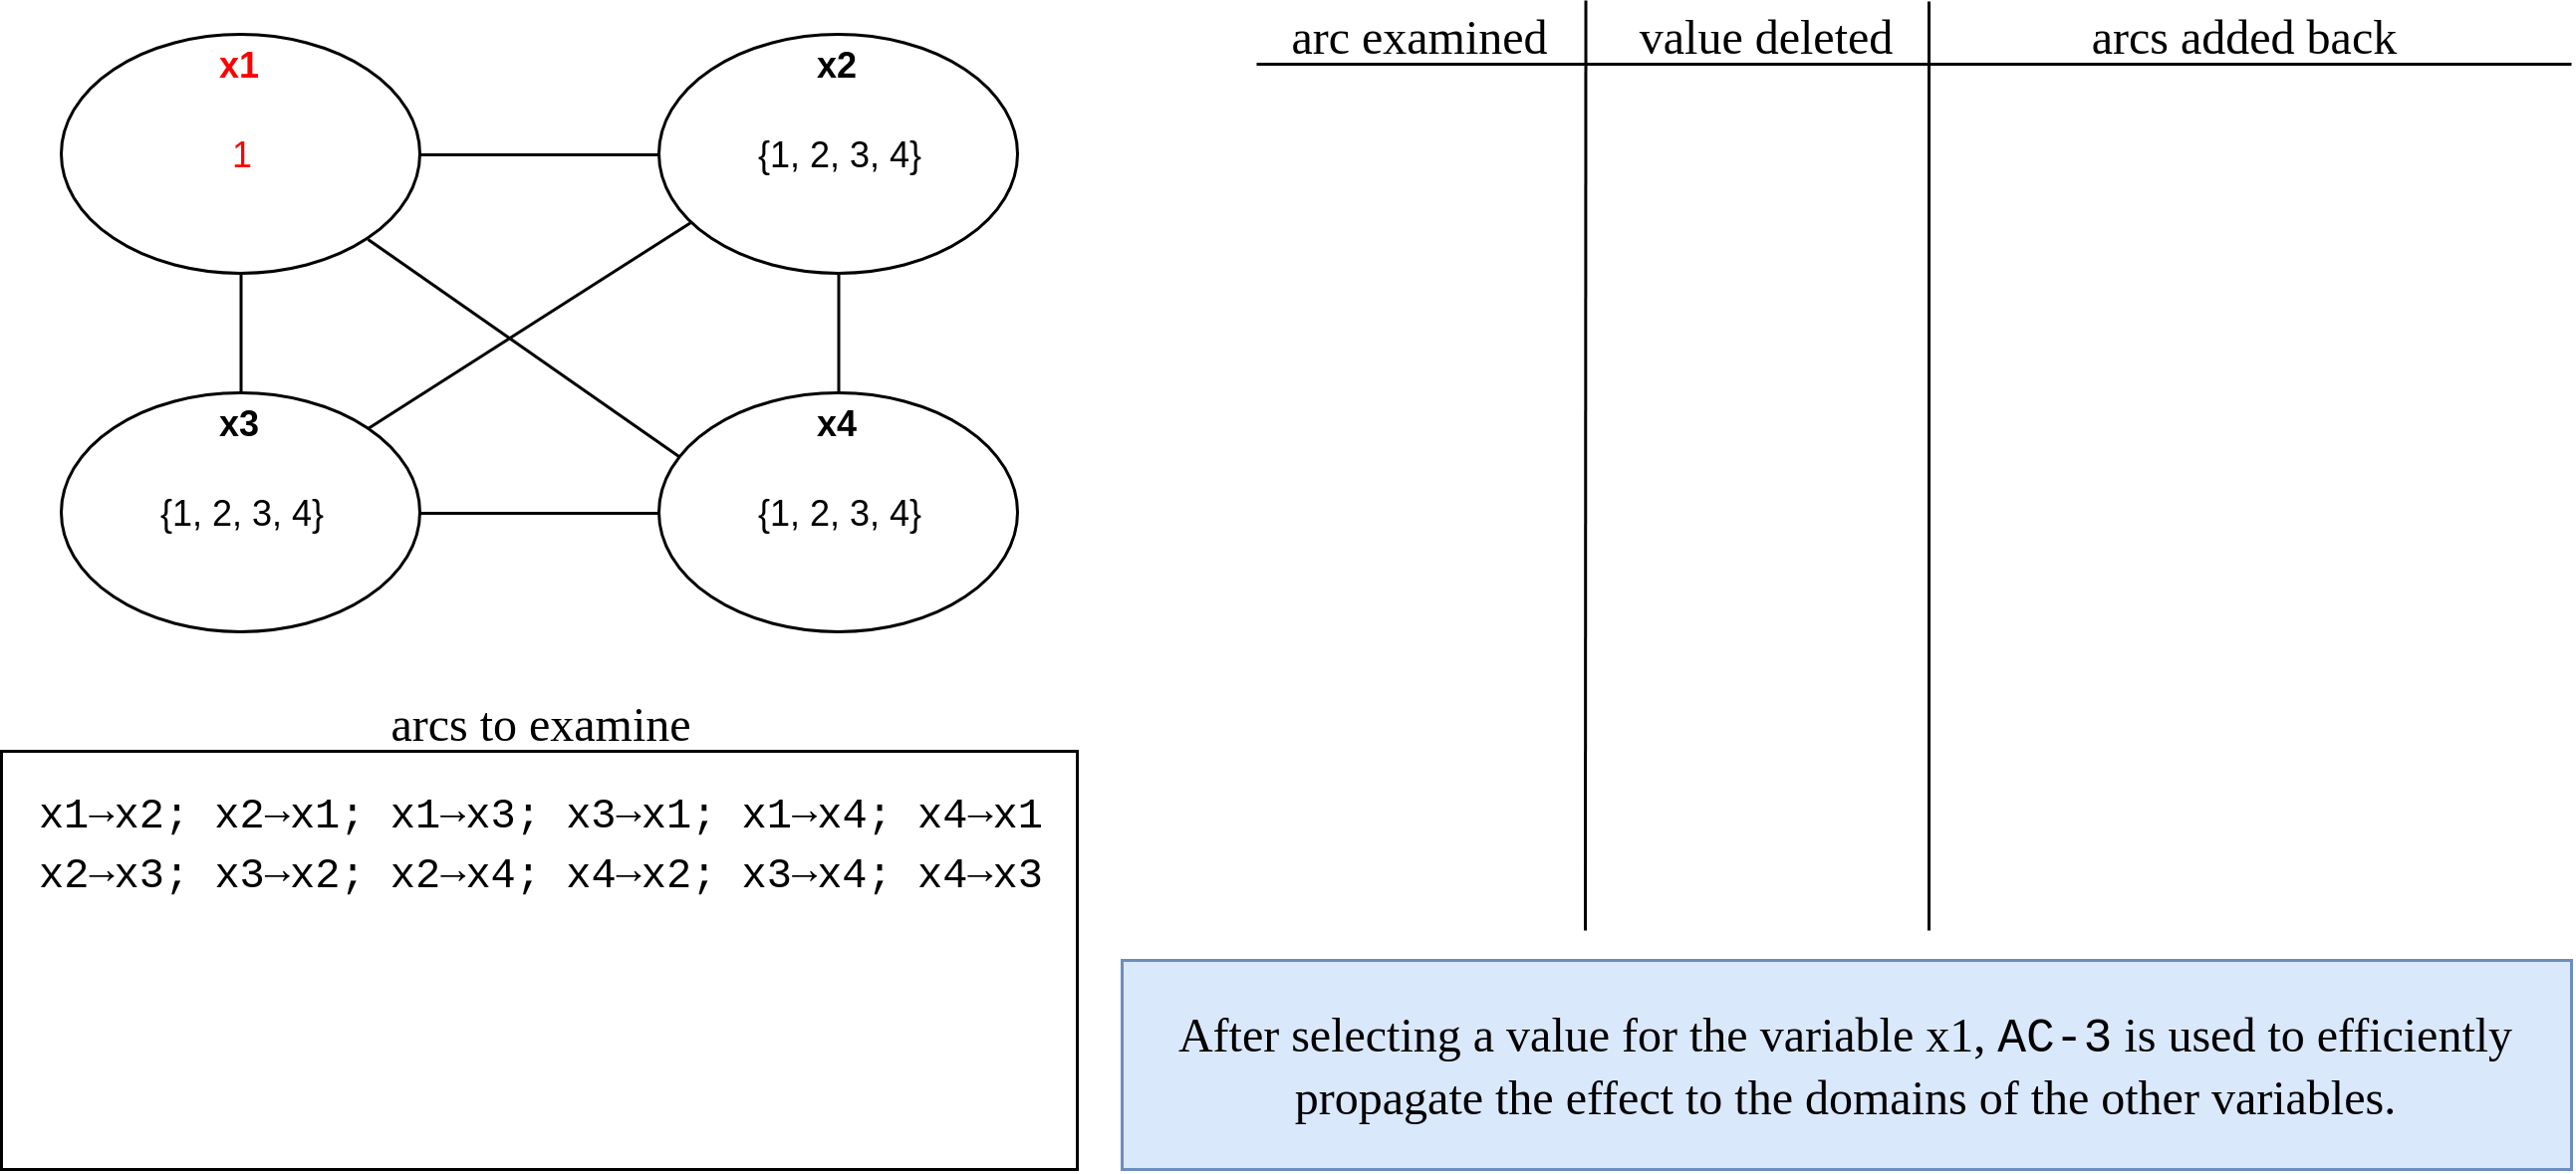

In [3]:
ac3_slides = SlideController('images/4queens_slide%02d.png', 8)

Note how in this example, the efficiencies of `AC-3` were unnecessary. In fact, a single pass of `AC-2` would have achieved the same result. Although this was the case for this specific instance, by adding arcs back to the queue to by examined, `AC-3` is more computationally efficient in general.

---

## Search Methods

In the previous 4-Queens example, constraint propagation via `AC-3` was not enough to find a satisfying complete assignment to the CSP. In fact, if `AC-3` had been applied to the empty 4-Queens chessboard, no domains would have been pruned because all variables were already arc consistent. In these cases, we must assign the next variable a value by *guessing and testing*.

This trial and error method of guessing a variable and testing if it is consistent is formalized in **search methods** for solving CSPs. As mentioned previously, a simple state-space search would be intractable as the number of variables and their domains increase. However, we will first examine state-space search in more detail and then move to a more clever search algorithm called backtrack search (BT) that checks consistency along the way.

### Generic Search for CSPs

As we have studied before, a generic search problem can be specified by the following four elements: (1) state space, (2) initial states, (3) operator, and (4) goal test. In a CSP, consider the following definitions of these elements:
- state space
    - partial assignment to variables at the current iteration of the search
- initial state
    - no assignment
- operator
    - add a new assignment to any unassigned variable, e.g., $x_i = a$, where $a\in D_i$.
    - child extends parent assignments with new
- goal test
    - all variables are assigned
    - all constraints are satisfied
   

### Making Search More Efficient for CSPs

The inefficiency of using the generic state-space search approaches we have previously employed is caused by the size of the state space. Recall that a simple state-space search (using either breadth-first search or depth-first search) has worst case performance of $O(b^d)$, where $b$ is the branching factor and $d$ is the search depth, as illustrated below (from 16.410/413, Lecture 3).

<img src="images/L3_16.413_treedefs.png" width="70%" />

In the above formulation of generic state-space search of CSPs, note that the branching factor is calculated as the sum of the maximum domain size $k$ for all variables $n$, i.e., $b = nk$. The search depth of a CSP is exactly $n$, because all variables must be assigned to be considered a solution. Therefore, the performance is exponential in the number of variables, $O([nk]^n)$.

This analysis fails to recognize that there are only $k^n$ possible complete assignments of the CSP. That is because the property of **commutativity** is ignored in the above formuation of CSP state-space search. CSPs are commutative because the order in which partial assignments are made do not affect the outcome. Therefore, by restricting the choice of assignment to a single variable at each node in the search tree, the runtime performance becomes only $O(k^n)$.

By combining this property with the idea that **extensions to inconsistent partial assignments are always inconsistent**, backtracking search shows how checking consistency after each assignment enables a more efficient CSP search.

<!--
With a better understanding of how expensive it can become to solve interesting problems with a simple state-space search, we are motivated to find a better searching algorithm. Two factors that contribute to the size of a search space are (1) variable ordering, and (2) consistency level.
We have already seen from the `AC-3` example on 4-Queens how enforcing arc-consistency on a network can result in the pruning of variable domains. This clearly reduces the search space of the CSP resulting in better performance from a search algorithm. Therefore, we will focus our discussion on the effects of **variable ordering**.
-->

### Backtracking Search

Backtracking (BT) search is based on depth-first search to choose values for one variable at a time, but it backtracks whenever there are no legal values left to assign. The state space is searched by extending the current partial solution with an assignment to unassigned variables. Starting with the first varible, the algorithm assigns a provisional value to each subsequent variable, checking value consistency along the way. If the algorithm encounters a variable for which no domain value is consistent with the previous assignments, a *dead-end* occurs. At this point, the search *backtracks* and the variable preceding the dead-end assignment is changed and the search continues. The algorithm returns when a solution is found, or when the search is exhausted with no solution.

#### Algorithm

```vhdl
1     if csp.assignment is complete and feasible then 
2       return assignment
3     var ← csp.get_unassigned_var()
4     for each value in csp.var_domain(var)
5       original_domain = csp.assign(var, value)
6       if csp.assignment is feasible then
7           result ← backtrack(csp)
8           if result ≠ failure then
9               return result
10      csp.unassign(var, value)
12      csp.restore_domain(original_domain)
12    return failure
```

#### Example

We can apply the backtrack search algorithm to the N-Queens problem. Note that this simple version of the algorithm makes finding a solution tractable for a handful of queens, but there are other improvements that can be made that are discussed in the following section.

In [8]:
queens, exec_time = nqueens_backtracking(4)
draw_nqueens([queens.assignment])
print("Solution found in %0.4f seconds" % exec_time)

<IPython.core.display.Javascript object>

Solution found in 0.0004 seconds


### Branch and Bound

Suppose we would like to find the *best* solution (in some sense) to the CSP. This amounts to solving the associated constraint optimization problem (COP), where our constraint network is now a 4-tuple, $\langle X, D_X, C, f \rangle$, where $X\in D_X$, $C: D_X \to \{\operatorname{True},\operatorname{False}\}$ and $f: D_x\to\mathbb{R}$ is a cost function. We would like to find the variable assignments $X$ that solve
\begin{array}{ll@{}ll}
\text{minimize}  & f(X) &\\
\text{subject to}& C(X) &
\end{array}

By adding a cost function $f(X)$, we turn a CSP into a COP, and we can use the **branch and bound algorithm** to find the solution with the lowest cost.

To find a solution of a COP we could surely explore the whole tree and then pick the leaves with the smallest cost value. However, one may want to integrate the optimization process into the search process allowing to **prune** even if no inconsistency has been detected yet.

The main idea behind branch and bound is the following: if the best solution so far has cost $c$, this is a _lower bound_ for all other possible solutions. So, if a partial solution has led to costs of $x$ (cost so far) and the best we can achieve for all other cost components is $y$ with $x + y < c$, then we do not need to continue in this branch.

Of course every time we prune a subtree we are implicitly making the search faster compared with full exploration. Therefore with a small overhead in the algorithm, we can improve (in the average case) the runtime.

#### Algorithm

```vhdl
 1  procedure BranchAndBound(cop)
 2    i ← 1; ai ← {}                                 ; initialize variable counter and assignments
 3    a_inc ← {}; f_inc ← ∞                          ; initialize incumbent assignment and cost
 4    Di´ ← Di                                       ; copy domain of first variable
 5    while 1 ≤ i ≤ n+1
 6      if i = n+1                                   ; "unfathomed" consistent assignment
 7          f_inc ← f(ai) and a_inc ← ai             ; updated incumbent
 8          i ← i - 2
 9      else
10          instantiate xi ← SelectValueBB()         ; Add to assignments ai; update Di
11          if xi is null                            ; if no value was returned,
12              i ← i - 1                            ;    then backtrack
13          else
14              i ← i + 1                            ; else step forward and
15              Di´ ← Di                             ;    copy domain of next variable.
16          end if
17      end if
18    end while
19    return incumbent X_inc and f_inc               ; Assignments exhausted, return incumbent
20  end
```
<br><br>
```vhdl
 1  procedure SelectValueBB()
 2    while Di´ ≠ ∅
 3      select an arbitrary element a ∈ Di´ and remove a from Di´
 4      ai ← ai ∪ {xi = a}
 5      if consistent(ai) and b(ai) < f_inc
 6        return a;
 7      end if
 8    end while                                      ; no consistent value
 9    return null
10  end
```

#### Example

Now let's revive our discussion on the map coloring problem. Imagine that we work at a company that wishes to print a colored map of the United States, so they need to choose a color for each state. Let's also imagine that the available colors are:

In [9]:
colors = [
  'red', 
  'green', 
  'blue', 
  '#6f2da8', #Grape
  '#ffbf00', #Amber
  '#01796f', #Pine
  '#813f0b', #Clay
  '#ff2000', #yellow
  '#ff66cc', #pink
  '#d21f3c'  #raspberry
  ]

The CEO asks the engineering department (they have one of course) to find a color assignment that satisfies the constraints as specified above in _Map Coloring_ and they arrive at the following solution:

Num. colors: 5


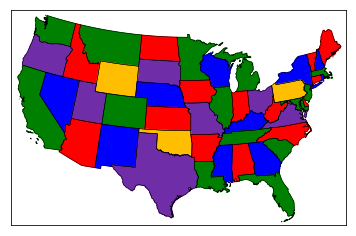

In [10]:
map_colors, num_colors = us_map_coloring(colors)
draw_us_map(map_colors)

Unfortunately, management is never happy and they complain that {{ num_colors }} colors are really too many. Can we do better? Yes, by adding an objective function $f$ that gives a cost proportional to the number of used colors, we can minimize $f$. This results in the following solution:

Num. colors: 4


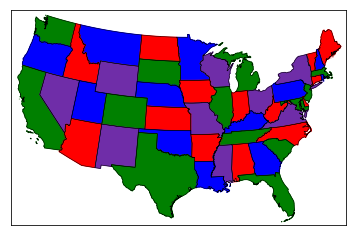

In [11]:
map_colors, opt_num_colors = us_map_coloring(colors, optimize=True)
draw_us_map(map_colors)

Fortunately we saved {{ num_colors - opt_num_colors }} color, well done!

---

## Extended Methods

The methods discussed in this section arise from viewing a CSP from different perspectives and from a combination of constraint propagation and search methods.

### BT Search with Forward Checking (BT-FC)

By interleaving inference from constraint propagation and search, we can obtain much more efficient solutions. A well-known way of doing this is by adding an arc consistency step to the backtracking algorithm. The result is called **forward checking**, which allows us to run search on graphs that have not already been pre-processed into arc consistent CSPs.

#### Algorithm

**Main Idea**: Maintain n domain copies for resetting, one for each search level i.

```vhdl
 1  procedure BTwithFC(csp)
 2    Di´ ← Di for 1 ≤ i ≤ n                  ; copy all domains
 3    i ← 1; ai = {}                          ; init variable counter, assignments
 4    while 1 ≤ i ≤ n
 5      instantiate xi ← SelectValueFC()      ; add to assignments, making ai
 6      if xi is null                         ; if no value was returned
 7        reset each Dk´ for k>i to
 8                its value before xi
 9                was last instantiated
10        i ← i - 1                           ; backtrack
11      else
12        i ← i + 1                           ; step forward
13      end if
14    end while
15    if i = 0
16      return "inconsistent"
17    else
18      return ai                             ; the instantiated values of {xi, ..., xn}
19  end
```

```vhdl
 1  procedure SelectValueFC()
 2    while Di´ ≠ ∅
 3      select an arbitrary element a ∈ Di´ and remove a from Di´
 4      for all k, i < k ≤ n
 5        for all values b ∈ Dk´
 6          if not consistent(a_{i-1}, xi=a, xk=b)
 7            remove b from Dk´
 8          end if
 9        end for
10        if Dk´ = ∅                          ; xi=a leads to a dead-end: do not select a
11          reset each Dk´, i<k≤n to its value before a was selected
12        else
13          return a
14        end if
15      end for
16    end while
17    return null
18  end
```
#### Example

In [4]:
queens, exec_time = nqueens_backtracking(4, with_forward_checking=True)
draw_nqueens([queens.assignment])
print("Solution found in %0.4f seconds" % exec_time)

<IPython.core.display.Javascript object>

Solution found in 0.0002 seconds


### BT-FC with Dynamic Variable Ordering

Traditional backtracking as it was introduced above uses a fixed ordering over variables and values. However, it is often better to choose ordering dynamically as the search proceeds. The idea is as follows. At each node during the search, choose:
- the most constrained variable; picking the variable with the fewest legal variables in its domain will minimize the branching factor,
- the least constraining value; choosing a value that rules out the smallest number of values of variables connected to the chosen variable via constraints will leave most options for finding a satisfying assignment.

#### Algorithm

#### Example

In [13]:
queens, exec_time = nqueens_backtracking(4, with_forward_checking=True, var_ordering='smallest_domain')
draw_nqueens([queens.assignment])
print("Solution found in %0.4f seconds" % exec_time)

<IPython.core.display.Javascript object>

Solution found in 0.0002 seconds


### Adaptive Consistency: Bucket Elimination

Another method of solving constraint problems entails eliminating constraints through bucket elimination. This method can be understood through the lens of Gaussian elimination, where equations (i.e., constraints) are added and then extra variables are eliminated. More formally, these operations can be thought of from the perspective of relations as join and projection operations.

Bucket elimination uses the join and projection operations on the set of constraints in order to project the constraint graph into a single variable. After solving for that variable, other constraints are solved for by back substitution just as you would in an algebraic system in Gaussian elimination.

#### Algorithm

#### Example

<div class="alert alert-danger">
    <b>TODO:</b> N-Queens example
</div>

---

# Symmetries

<img src="images/escher_2.jpg" align="center"/>
<div style="text-align: right"> M. C. Escher </div>


## Introduction

A CSP often exhibit some symmetries, which are mappings that preserve satisfiability of the CSP. They are particularly harmful when we are looking for all possible valid assignment of a CSP since due to symmetries, we have many solutions that are just a symmetric solution of another one.

\begin{definition} \label{def:symmetry}
(Symmetry). For any CSP instance $P = \langle X, D, C \rangle$, a solution symmetry of $P$ is a permutation of the set $X\times D$ that preserves the set of solutions to $P$.
\end{definition}


In other words, a solution symmetry is a bijective mapping defined on the set of possible variable-value pairs of a CSP, that maps solutions to solutions.

### Why is symmetry important? 

A principal reason for identifying symmetry in CSPs is to reduce search effort by not exploring assignments that are symmetrically equivalent to assignments considered elsewhere in the search. Clearly, if the solution symmetry group is larger than the constraint symmetry group, there will potentially be a greater search reduction from using the solution symmetries, if they can somehow be identified in advance.

### Case Study: symmetries in N-Queens problem

We already seen the n-Queens problem. Let's see all the solution of a $4 \times 4$ chessboard.


In [ ]:
queens = nqueens(4)
draw_nqueens(queens, all_solutions=True)

There are exactly 2 solutions. 

It's easy to notice the two are the same solution if we flip (or rotate) the chessboard. 

### Interactive examples

All the following code snippets are a refinement of the original $n$-Queens problem where we modify the problem to reduce the number of symmetries. Feel free to explore how the number of solution of the $n$-Queens problem changes when we change symmetry braking strategy and $n$.

You can use the following slider to change $n$, than press the button `Update cells...` to quickly update the results of the models.

In [4]:
n = 5
def update_n(x):
    global n
    n = x
interact(update_n , x=widgets.IntSlider(value=n, min=1,max=12,step=1, description='Queens:'));

interactive(children=(IntSlider(value=5, description='Queens:', max=12, min=1), Output()), _dom_classes=('widg…

In [ ]:
## Update all cells dependent from the slider with the following button
button = widgets.Button(description="Update cells...")
display(button)
button.on_click(autoupdate_cells)

## Avoid symmetries

### Adding Constraints Before Search

Symmetry in CSPs is usually identified, in practice, by applying human insight: the programmer sees that some transformation would translate a hypothetical solution into another hypothetical solution. Then the programmer can try to formalize some constraint that preserves solutions but remove some of the symmetries.

For $n$ = {{n}} the $n$-Queens problem has {{ len(nqueens(n)) }} solutions. One naive way to remove some of the symmetric solutions is to restrict the position for some of the queens, for example, we can say that the first queen should be on the top half of the chess board by imposing an additional constraint like

```
constraint queens[0] <= n div 2;
```

This constraint should remove approximately half of the symmetries. Let's try the new model!

In [ ]:
%%minizinc --all-solutions --statistics -m bind
include "globals.mzn";
int: n;
array[0..n-1] of var 0..n-1: queens;

constraint all_different(queens);
constraint all_different([queens[i]+i | i in 0..n-1]);
constraint all_different([queens[i]-i | i in 0..n-1]);

constraint queens[0] <= n div 2;

solve satisfy;

If you play with $n$ you would notice that for $n=4$ it preserves all the solutions, it will start to prune some out for $n>4$.

This approach is fine if done correctly can greatly readuce search space, but can obviously lose solutions if done incorrectly.

To address the problem in a better way we need some formal tool.

### Chessboard symmetries

If we look at the chessboard we can notice that has eight geometric symmetries, one for each geometric operation (like reflections and rotations) we can do, in particular they are:

- identity (no-reflections) $id$ (we always include the identity)
- horizontal reflection $r_x$
- vertical reflection $r_y$
- reflectins along the two diagonal axes ($r_{d_1}$ and $r_{d_2}$)
- rotations through $90$&deg;, $180$&deg; and $270$&deg; ($r_{90}$, $r_{180}$, $r_{270}$)

If we label the sixteen squares of a $4 \times 4$ chessboard with the numbers 1 to 16, we can graphically see how symmetries move cells. 

<img src="images/4x4_symm.png" width="80%" align="center"/>

Now it's easy to see that a symmetry is a **permutation** that act on a point: for example if a queen is at $(2,1)$, corresponding to the element $2$ in $id$, due to symmetry $r_{90}$, it moves to (4,2).

One useful form to write a permutation is in _Cauchy form_, for example for $r_{90}$

\begin{equation}
r_{90} : \left( \begin{array} { c c c c c c c c c } 
1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 & 14 & 15 & 16\\ 
13 & 9 & 5 & 1 & 14 & 10 & 6 & 2 & 15 & 11 & 7 & 3 & 16 & 12 & 8 & 4
\end{array} \right)
\end{equation}

What this notation says is that an element in position $i$ in the top row, is moved to the corresponding position of the bottom row. For example $1$ &rarr; $13$, $2$ &rarr; $9$, $3$ &rarr; $5$ and so on.

This form will help us to write constraints to remove unwanted permutations compactly.

### The Lex-Leader Method

Puget proved that whenever a CSP has symmetry that can be expressed as permutations of the variables, it is possible to find a _'reduced form'_, with the symmetries eliminated, by adding constraints to the original problem  \cite{Puget2003}. Puget found such a reduction for three simple constraint problems, and showed that this reduced CSP could be solved more efficiently than in its original form. 

The intuition is rather simple, for each equivalence class of solutions (permutation), we predefine one to be the **canonical solution**. We achieve this by choosing a static variable ordering and imposing the **lexicographic order** for each permutation. This method is called **lex-leader**.

For example let's consider a problem where we have three variables $x_1$ $x_2$ and $x_3$ subject to `alldifferent` constraint and domain {A,B,C}. This problem has $3!$ solutions (where $3!-1$ are symmetric solutions of the same solution). Let's say that our canonical solution is ABC, and we want to prevent ACB from being a solution, the lex-leader method would impose the following additional constraint

$$ x_1\,x_2\,x_3 \preceq_{\text{lex}} x_1\,x_3\,x_2 $$

infact, if $x = (\text{A},\text{C},\text{B})$ the constraint is not satisfied

$$ \text{A}\text{C}\text{B}\,\, \npreceq_{\text{lex}} \text{A}\text{B}\text{C} $$

Adding constraints like this for all $3!$ permutations will remove all symmetric solution, leaving exactly one solution (ABC). All the other can be recovered applying all the symmetries.

In general, if we have a permutation $\pi$ that generates a symmetric solution that we wish to remove, we would impose an additional constraint usually expressed as

$$ x_1 \ldots x_k \preceq_{\text{lex}} x_{\pi (1)} \ldots x_{\pi (k)}  $$

where $\pi(i)$ is the index of the variable after the permutation.

Unfortunately, for the n-Queens problem formulated as we have seen, this technique does not immediately apply, because some of its symmetries cannot be described as permutations of the `queens` array.

The trick to overcoming this limitation is to express the n-Queens problem in terms of Boolean variables that model, for each cell of the board, whether it contains a queen or not. Now all the symmetries can be modeled as permutations of this array using Cauchy form. 

Since the main constraints of the n-Queens problem are much easier to express with the integer `queens` array, we use both models together connecting them using a _channeling constraints_.

In [ ]:
%%minizinc --all-solutions --statistics -m bind
include "globals.mzn";

int: n;
array[0..n-1,0..n-1] of var bool: qb;
array[0..n-1] of var 0..n-1: q;

constraint all_different(q);
constraint all_different([q[i]+i | i in 0..n-1]);
constraint all_different([q[i]-i | i in 0..n-1]);

constraint % Channeling constraint
    forall (i,j in 0..n-1) ( qb[i,j] <-> (q[i]=j) );

constraint % Lexicographic symmetry breaking constraints
    lex_lesseq(array1d(qb), [ qb[j,i] | i in reverse(0..n-1), j in 0..n-1 ]) /\ % r_{90}
    lex_lesseq(array1d(qb), [ qb[i,j] | i,j in reverse(0..n-1) ]) /\            % r_{180}
    lex_lesseq(array1d(qb), [ qb[j,i] | i in 0..n-1, j in reverse(0..n-1) ]) /\ % r_{270}
    lex_lesseq(array1d(qb), [ qb[i,j] | i in reverse(0..n-1), j in 0..n-1 ]) /\ % r_{x}
    lex_lesseq(array1d(qb), [ qb[i,j] | i in 0..n-1, j in reverse(0..n-1) ]) /\ % r_{y}
    lex_lesseq(array1d(qb), [ qb[j,i] | i,j in 0..n-1 ]) /\                     % r_{d_1}
    lex_lesseq(array1d(qb), [ qb[j,i] | i,j in reverse(0..n-1) ]);              % r_{d_2}

solve satisfy;

In this model the constraint `lex_lesseq(array_1, array_2)` implements the lexicographic operator $\preceq_{\text{lex }}$ between `array_1` and `array_2`. Notice that `array_2` represent the permutation fo each of the geometric symmetry of the chessboard (except the identity).
 
Using the lex-leader method we reduced the number of solutions but we also added a lot of constraints...

### Double-Lex

When dealing with a matrix of decision variables often we have that, given a solution, any permutation of the rows (or columns) is also a solution. This class of symmetry is called _row and column symmetries_.

We can certainly use the lex-leader method to break all symmetries, but in a $n \times n$ matrix with rows and column symmetry we would add $n!m!$ constraints. Adding so many constraints can be counter-productive. 

When breaking all symmetries proves too difficult, it is often possible to achieve good results by breaking a smaller
set of symmetries. One method to do this for row and column symmetries is **double-lex** (Flener et al. 2002). The idea is to impose the ordering on the rows and on the columns **independently**. This produces only $n + m − 2$ symmetry breaking constraints.

One example where the double-lex can be applied is the problem seen during the course assignments: _Buddies_. In that problem, we could permute each element on each row (i.e., seat assignment) independently while preserving the same solution. Similarly, we could also permute each column independently (i.e., swap the 20-minute segments). This is a typical case where the double-lex is effective and cheap to implement.

<div class="alert alert-block alert-info">
The double-lex is not applicable to the n-Queens problem, because not all column (or row) permutation preserve the solution.
</div>


## Symmetry breaking constraints

### Soundness and completeness

Two important properties of symmetry breaking constraints are **soundness** and **completeness**, a set of symmetry breaking constraints:
- is **sound** if and only if it leaves at least one solution in each symmetry class
- is **complete** if and only if it leaves at most one solution in each symmetry class

All the approaches we used so far in the n-Queens problem are sound and complete since they leave at least one solution in the only symmetry class available (geometric symmetries). Other problems might have different symmetry classes and it is very important the constraints added to remove one symmetry don't remove desiderable solutions from the problem.


### Intractability of Breaking Symmetry

It is worth to mention that lex-leader requires one constraint for each element of the group. 
In the case of a matrix with $m$ rows and $n$ columns, rows and column symmetry, this is $m!n!$, which is impractical in general. Therefore there are many cases where lex-leader is applicable but impractical.

\begin{theorem} \label{theo:simple_ordering_NP}
(Walsh 2011) Given any _simple_ ordering, there exists a symmetry group such that deciding if an assignment is smallest in its symmetry class according to this ordering is NP-hard.
\end{theorem}

In other words, Walsh proved that breaking symmetry completely by adding constraints to eliminate symmetric solutions is computationally intractable in general. More specifically, he proves that, given any simple variable ordering, deciding if an assignment is the smallest in its symmetry class is NP-hard.

An alternative full symmetry breaking is to break some symmetry by posting just a subset of the lex-leader constraints, for example, the double-lex.

\begin{theorem} \label{theo:lex2_NP}
(Katsirelos, Narodytska, and Walsh 2010) Propagating the double-lex constraint is NP-hard.
\end{theorem}

In other words, this theorem states that there is no efficient algorithm to restrict variable domain after an assignment.

Since breaking symmetry appears intractable in general, a major research direction is to identify special cases where the symmetry group is more tractable in practice.

## Reduce the set of Symmetry breaking constraints

Lex-leader constraints can be simplified to remove redundancies. For example, imagine having the following lexicographic constraint

$$ x_1\,x_2\,x_3\,x_4\,x_5,\,x_6 \preceq_{\text{lex}}x_1\,x_3\,x_2\,x_4\,x_6,x_5 $$

We can remove the first and fourth variables from each tuple, since clearly $x_1 = x_1$ and $x_4 = x_4$, obtaining

$$ x_2\,x_3\,x_5,\,x_6 \preceq_{\text{lex}}x_3\,x_2\,x_6,x_5 $$

But we can also notice that if $x_2 < x_3$ the constraint is satisfied whatever the other values, and otherwise we have $x_2 = x_3$ to satisfy the constraint. In other words, if the second variables in the tuples are relevant, they must be equal. Similarly for $x_5$ and $x_6$, so in fact, the constraint is equivalent to 

$$ x_2\,x_5\preceq_{\text{lex}}x_3\,x_5 $$

Since $\preceq_{\text{lex}}$ is transitive we can go further, treating the constraints as a set and not just individually. This would most probably help us to reduce the size of the constraint even more.

Unfortunately, the approach outlined here does not get around the fundamental problem of the exponential number of symmetries. However, the approach does illustrate how the set of constraints can be simplified, and we will see in the next section a particular case where the results are quite dramatic.

### Lex constraint decomposition

We can decompose the lex constraint of the form $x_1\ldots x_2 \preceq_{\text{lex }} y_1\ldots y_2$ to a conjunction of clauses like
$$ \left(x_1 = y_1 \right),\ldots,\left(x_k = y_k\right)\rightarrow x_{k+1}\leq y_{k+1} $$
We call clauses of this form lex implications.

In practice happens that many of the lex-implications are redundant \cite{Codish2018}. Given this observation, we can ask ourself the direct question: how many lex implications are required to express a complete symmetry break?

### Reduce implications

In a recent paper \cite{Codish2018}, the authors develop a method to find a complete and compact set of symmetry breaking constraints. Basically, the algorithm iterates over the set of lex implications, and checks for each of them if they are redundant. 

Let define $\phi$ the set of constraints expressed as boolean formula, and $\psi$ the set of lex implications used to break the symmetries in the solution space defined by $\phi$.

Given these two sets, the idea behind the reduction is quite intuitive: remove one clause from the formula, and check if there is a solution which would be forbidden by this clause, if this is not the case, the clause is redundant and can be removed. 

We can notice that the number of clauses which can actually be removed depends on the order in which clauses are checked, thus the reduction splits in two phases

- The first phase is shown in Algorithm 1. We rank the clauses by checking if a clause $c\in\phi$ is redundant. If so, we compute a subset $\psi\subseteq\varphi^\prime$ of clauses which makes $c$ redundant, and increase the ranking of all clauses within this set. 

The rationale is that removing these clauses is more likely make other clauses no longer redundant, and so increase the size of the final symmetry break.

<img src="images/reduce_alg_1.png" width="80%" align="center"/>

- The second stage is shown in Algorithm 2. We sort the clauses by ranking, so clauses which were frequently the cause of redundancy appear as late as possible. Then remove the a clauses if there is not a solution which would be forbidden.

<img src="images/reduce_alg_2.png" width="80%" align="center"/>

This approach can be applied to any ordering based on lexicographic 

### Example

In their paper \cite{Codish2018} show some result of their method applied to a generic matrix model

<table>
  <tr>
    <th>n</th>
    <th colspan="2">Double-Lex</th>
    <th colspan="2">All Permutations</th>
  </tr>
  <tr>
    <td></td>
    <td>Original</td>
    <td>Reduced</td>
    <td>Original</td>
    <td>Reduced</td>
  </tr>
  <tr>
    <td>3</td>
    <td>12</td>
    <td>12</td>
    <td>48</td>
    <td>13</td>
  </tr>
  <tr>
    <td>4</td>
    <td>24</td>
    <td>24</td>
    <td>312</td>
    <td>32</td>
  </tr>
  <tr>
    <td>5</td>
    <td>40</td>
    <td>40</td>
    <td>2440</td>
    <td>71</td>
  </tr>
  <tr>
    <td>6</td>
    <td>60</td>
    <td>60</td>
    <td>21660</td>
    <td>148</td>
  </tr>
  <tr>
    <td>7</td>
    <td>84</td>
    <td>84</td>
    <td>211764</td>
    <td>310</td>
  </tr>
</table>


It is interesting to note that with the complete symmetry break it is possible to reduce the number of implications quite drastically but double-lex has no redundant implications.

### Conclusion

Removing reduntand clause can be costly due to the use of a SAT solver. But if an instance of the same size needs to be solved several times but with different values it can greatly improve the search time since the reduction can be done offline just once.

# References

(<a id="cit-Dechter2003" href="#call-Dechter2003">Dechter, 2003</a>) Rina Dechter, ``_Constraint Processing_'',  2003.

(<a id="cit-AIMA" href="#call-AIMA">Russell and Norvig, 2003</a>) Stuart J. Russell and Peter Norvig, ``_Artificial Intelligence: A Modern Approach_'',  2003.

(<a id="cit-Mackworth1977" href="#call-Mackworth1977">Mackworth, 1977</a>) Mackworth Alan K., ``_Consistency in Networks of Relations_'', Artif. Intell., vol. 8, number 1, pp. 99--118,  1977.  [online](http://dx.doi.org/10.1016/0004-3702(77)90007-8)

(<a id="cit-Puget2003" href="#call-Puget2003">Puget, 1993</a>) J.F. Puget, ``_On the satisfiability of symmetrical constrained satisfaction problems_'', Methodologies for Intelligent Systems,  1993.

(<a id="cit-Codish2018" href="#call-Codish2018">Codish, Ehlers <em>et al.</em>, 2018</a>) M. Codish, T. Ehlers, G. Gange <em>et al.</em>, ``_Breaking Symmetries with Lex Implications_'', FLOPS,  2018.

